# 텍스트 분할의 5단계

이 튜토리얼에서는 텍스트 분할의 5단계를 살펴봅니다. 이는 재미와 교육적 목적으로 작성된 비공식 목록입니다.

ChatGPT에 긴 텍스트를 입력하려고 했지만 너무 길다는 메시지를 받은 적이 있으신가요? 아니면 애플리케이션의 장기 기억력을 향상시키려고 하지만 여전히 제대로 작동하지 않는 경우가 있습니다.

언어 모델 애플리케이션의 성능을 향상시키는 가장 효과적인 전략 중 하나는 대용량 데이터를 더 작은 조각으로 분할하는 것입니다. 이를 호출 분할(call splitting) 또는 청킹(chunking)이라고 합니다(이 두 용어는 혼용하여 사용하겠습니다). 멀티모달 환경에서는 이미지에도 분할이 적용됩니다.

많은 내용을 다룰 예정이지만, 끝까지 읽으면 청킹 이론, 전략, 그리고 더 자세히 알아볼 수 있는 자료들을 확실히 이해하게 될 것입니다.

**Levels Of Text Splitting**
* **Level 1: [Character Splitting](#CharacterSplitting)** - 간단한 데이터의 정적 문자 청크
* **Level 2: [Recursive Character Text Splitting](#RecursiveCharacterSplitting)** - 구분자 목록을 기반으로 한 재귀적 청킹
* **Level 3: [Document Specific Splitting](#DocumentSpecific)** - 다양한 문서 유형(PDF, Python, Markdown)에 대한 다양한 청킹 방법
* **Level 4: [Semantic Splitting](#SemanticChunking)** - 임베딩 기반 청킹
* **Level 5: [Agentic Splitting](#AgenticChunking)** - 에이전트와 유사한 시스템을 사용하여 텍스트를 분할하는 실험적 방법입니다. 토큰 비용이 $0.00로 갈 것으로 예상되는 경우에 유용합니다.
* **\*Bonus Level:\*** **[Alternative Representation Chunking + Indexing](#BonusLevel)** - 검색 및 인덱싱에 도움이되는 raw 텍스트의 파생 표현

**Notebook resources:**
* [Video Overview]() - Walkthrough of this code with commentary
* [ChunkViz.com](https://www.chunkviz.com/) - Visual representation of chunk splitting methods
* [RAGAS](https://github.com/explodinggradients/ragas) - Retrieval evaluation framework

This tutorial was created with ❤️ by [Greg Kamradt](https://twitter.com/GregKamradt). MIT license, attribution is always welcome.

This tutorial will use code from LangChain (`pip install langchain`) & Llama Index (`pip install llama-index`)

**Evaluations**

검색 평가에서 청킹 전략을 테스트하는 것이 중요합니다. 애플리케이션 성능이 좋지 않다면 청킹 방식을 어떻게 사용하든 의미가 없습니다.

Eval Frameworks:

* [LangChain Evals](https://python.langchain.com/docs/guides/evaluation/)
* [Llama Index Evals](https://docs.llamaindex.ai/en/stable/module_guides/evaluating/root.html)
* [RAGAS Evals](https://github.com/explodinggradients/ragas)

성공 여부는 도메인에 따라 다르므로 각 방법에 대한 평가 결과를 데모로 보여드리지 않겠습니다. 제가 임의로 선택한 평가 결과가 귀하의 데이터에 적합하지 않을 수 있습니다. 다양한 청킹 전략에 대한 엄격한 평가에 협력하고 싶으신 분은 contact@dataindependent.com으로 연락해 주세요.

If you only walk away from this tutorial with one thing have it be the **The Chunking Commandment**

**The Chunking Commandment:** 여러분의 목표는 그저 덩어리로 나누는 것이 아니라, 나중에 가치 있게 검색할 수 있는 형식으로 데이터를 얻는 것입니다.

## Level 1: Character Splitting <a id="CharacterSplitting"></a>
문자 분할은 텍스트를 분할하는 가장 기본적인 방법입니다. 내용이나 형식에 관계없이 텍스트를 N자 크기의 덩어리로 나누는 과정입니다.

이 방법은 어떤 응용프로그램에도 권장되지 않습니다. 하지만 기본 사항을 이해하기 위한 좋은 시작점입니다.

* **Pros:** 쉽고 간단함
* **Cons:** 매우 엄격하고 텍스트 구조를 고려하지 않음

Concepts to know:
* **Chunk Size** - 청크에 포함할 문자 수입니다. 50, 100, 100,000 등.
* **Chunk Overlap** - 연속된 청크를 겹치게 할 횟수입니다. 이는 단일 컨텍스트를 여러 조각으로 나누는 것을 방지하기 위한 것입니다. 여러 청크에 중복 데이터가 생성될 수 있습니다.

먼저 몇 가지 샘플 텍스트를 가져와 보겠습니다.

In [1]:
text = "This is the text I would like to chunk up. It is the example text for this exercise"

Then let's split this text manually

In [2]:
# Create a list that will hold your chunks
chunks = []

chunk_size = 35  # Characters

# Run through the a range with the length of your text and iterate every chunk_size you want
for i in range(0, len(text), chunk_size):
    chunk = text[i : i + chunk_size]
    chunks.append(chunk)
chunks

['This is the text I would like to ch',
 'unk up. It is the example text for ',
 'this exercise']

축하합니다! 첫 번째 텍스트를 분할했습니다. 아직 갈 길이 멀지만 첫 발을 내딛고 있습니다. 언어 모델 실무자가 되신 것처럼 느끼시나요?

언어 모델 환경에서는 텍스트 작업을 할 때 원시 문자열을 다루지 않습니다. 문서를 다루는 것이 더 일반적입니다. 문서는 관심 있는 텍스트뿐만 아니라 나중에 필터링 및 조작을 쉽게 해 주는 추가 메타데이터를 담고 있는 객체입니다.

문자열 목록을 문서로 변환할 수도 있지만, 처음부터 문서를 만드는 것이 더 좋습니다.

LangChains의 `CharacterSplitter`를 로드하여 이 작업을 수행해 보겠습니다.

In [3]:
from langchain.text_splitter import CharacterTextSplitter

이제 이 텍스트 분할기를 불러오겠습니다. `chunk overlap`과 `separator`를 지정해야 합니다. 그렇지 않으면 좋지 않은 결과가 나옵니다. 이 부분은 다음에 다루겠습니다.

In [4]:
text_splitter = CharacterTextSplitter(
    chunk_size=35, chunk_overlap=0, separator="", strip_whitespace=False
)

그러면 `create_documents`를 통해 텍스트를 실제로 분할할 수 있습니다. 참고: `create_documents`는 텍스트 목록을 요구하므로, 저희처럼 텍스트 하나만 있는 경우 `[]`로 묶어야 합니다.

In [5]:
text_splitter.create_documents([text])

[Document(metadata={}, page_content='This is the text I would like to ch'),
 Document(metadata={}, page_content='unk up. It is the example text for '),
 Document(metadata={}, page_content='this exercise')]

아까와 같은 청크지만 이번에는 document 안에 있다는 점에 유의하세요. 이 문서들은 LangChian의 다른 부분과 호환이 잘 됩니다. 또한 두 번째 청크 끝 부분의 공백이 누락된 것도 눈에 띕니다. 이는 Langchian이 해당 공백을 제거하기 때문입니다.[this line](https://github.com/langchain-ai/langchain/blob/f36ef0739dbb548cabdb4453e6819fc3d826414f/libs/langchain/langchain/text_splitter.py#L167) 에서 공백 제거 위치를 확인할 수 있습니다. `strip_whitespace=False`를 사용하면 이 문제를 방지할 수 있습니다.

**Chunk Overlap & Separators**

**Chunk overlap**은 청크들을 혼합하여 청크 #1의 끝 부분과 청크 #2의 머리 부분을 동일하도록 만들고, 나머지 청크들도 같은 방식으로 혼합합니다.

이번에는 4라는 값으로 overlap을 해보겠습니다. 즉, 4개의 문자가 overlap 됩니다.

In [6]:
text_splitter = CharacterTextSplitter(chunk_size=35, chunk_overlap=4, separator="")

In [7]:
text_splitter.create_documents([text])

[Document(metadata={}, page_content='This is the text I would like to ch'),
 Document(metadata={}, page_content='o chunk up. It is the example text'),
 Document(metadata={}, page_content='ext for this exercise')]

청크는 같지만, 1과 2, 2와 3 사이에 겹치는 부분이 있는 것을 보세요. 청크 1의 끝 부분에 있는 'o ch'와 청크 2의 머리 부분에 있는 'o ch'와 일치 합니다.

이를 더 잘 시각화할 방법을 찾고 싶어서 [ChunkViz.com](www.chunkviz.com)을 만들어서 보여드리려고 합니다. 같은 텍스트가 어떻게 보이는지 보여드리겠습니다.

<div style="text-align: center;">
    <img src="static/ChunkVizCharacter34_4_w_overlap.png" alt="image" style="max-width: 800px;">
</div>

static/ChunkVizCharacterRecursive.png

두 개의 겹치는 섹션으로 세 가지 색상이 어떻게 표현되는지 살펴보세요.

**Separators**는 분할 기준으로 삼을 문자 시퀀스 입니다. 예를 들어, 데이터를 'ch' 단위로 나누고 싶다면 구분자를 지정할 수 있습니다.

In [8]:
text_splitter = CharacterTextSplitter(chunk_size=35, chunk_overlap=0, separator="ch")

In [9]:
text_splitter.create_documents([text])

[Document(metadata={}, page_content='This is the text I would like to'),
 Document(metadata={}, page_content='unk up. It is the example text for this exercise')]

#### Llama Index

[Llama Index](https://www.llamaindex.ai/)는 청킹 및 인덱싱 프로세스의 유연성을 제공하는 훌륭한 선택입니다. 기본적으로 노드 관계를 제공하여 나중에 검색하는 데 도움이 됩니다.

문장 분할기를 살펴보겠습니다. 문자 분할기와 유사하지만, 기본 설정을 사용하면 문장 단위로 분할됩니다.

In [10]:
from llama_index.core.text_splitter import SentenceSplitter
from llama_index.core import SimpleDirectoryReader

splitter를 로드하세요.

In [11]:
splitter = SentenceSplitter(
    chunk_size=200,
    chunk_overlap=15,
)

문서를 로드합니다.

In [12]:
documents = SimpleDirectoryReader(input_files=["./data/PGEssays/mit.txt"]).load_data()

노드를 생성하세요. 노드는 문서와 비슷하지만 더 많은 관계 데이터가 추가됩니다.

In [13]:
nodes = splitter.get_nodes_from_documents(documents)

그런 후에 하나를 살펴봅시다.

In [14]:
nodes[0]

TextNode(id_='c69f59b2-207f-48d0-8a5a-ebd42e68c6c1', embedding=None, metadata={'file_path': 'data\\PGEssays\\mit.txt', 'file_name': 'mit.txt', 'file_type': 'text/plain', 'file_size': 36045, 'creation_date': '2025-08-13', 'last_modified_date': '2024-06-18'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='362cbc5d-213b-433d-8bfd-c67a6e723ffb', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': 'data\\PGEssays\\mit.txt', 'file_name': 'mit.txt', 'file_type': 'text/plain', 'file_size': 36045, 'creation_date': '2025-08-13', 'last_modified_date': '2024-06-18'}, hash='6c9c429b644eda48da380b646091cbf7389dac1a6d1a7d8865dcad09ecb8d00a'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='893443ab-d159-4

보시다시피 Llama Index 노드에는 훨씬 더 많은 관계 데이터가 보관되어 있습니다. 이 부분에 대해서는 나중에 자세히 설명하겠습니다. 너무 앞서가고 싶지는 않거든요.

기본적인 Character 분할은 아마 몇몇 애플리케이션에만 유용할 겁니다. 아마 여러분의 애플리케이션에도 유용할 겁니다.

## Level 2: 재귀 Character 텍스트 분할
<a id="RecursiveCharacterSplitting"></a>
복잡성을 한단계 높여봅시다.

레벨 1의 문제점은 문서 구조를 전혀 고려하지 않는다는 것입니다. 단순히 고정된 문자 수로만 분할합니다.

재귀적 문자 텍스트 분할기를 사용하면 이 문제를 해결할 수 있습니다. 이 분할기를 사용하면 문서를 분할하는 데 사용할 일련의 구분 기호를 지정할 수 있습니다.

LangChain의 기본 구분 기호는 [여기](https://github.com/langchain-ai/langchain/blob/9ef2feb6747f5a69d186bd623b569ad722829a5e/libs/langchain/langchain/text_splitter.py#L842)에서 확인할 수 있습니다. 하나씩 살펴보겠습니다.

* "\n\n" - 2개의 새 줄 또는 일반적으로 단락을 나누는 것입니다.
* "\n" - 새 줄
* " " - 공백
* "" - 문자들

마침표(".")가 왜 목록에 포함되지 않았는지 잘 모르겠네요. 아마 보편적이지 않은 것 같아요. 아시는 분 계시면 알려주세요.

이건 빠른 애플리케이션을 만들 때 가장 먼저 선택하는 스위스 나이프 같은 분할기입니다. 어떤 분할기로 시작해야될지 모르겠다면, 이 분할기가 좋은 선택이 될 겁니다.

한번 써볼까요?

In [15]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

그럼 더 큰 텍스트를 로드해 봅시다.

In [16]:
text = """
One of the most important things I didn't understand about the world when I was a child is the degree to which the returns for performance are superlinear.

Teachers and coaches implicitly told us the returns were linear. "You get out," I heard a thousand times, "what you put in." They meant well, but this is rarely true. If your product is only half as good as your competitor's, you don't get half as many customers. You get no customers, and you go out of business.

It's obviously true that the returns for performance are superlinear in business. Some think this is a flaw of capitalism, and that if we changed the rules it would stop being true. But superlinear returns for performance are a feature of the world, not an artifact of rules we've invented. We see the same pattern in fame, power, military victories, knowledge, and even benefit to humanity. In all of these, the rich get richer. [1]
"""

텍스트 분할기를 만들어 봅시다.

In [17]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=65, chunk_overlap=0)

In [18]:
text_splitter.create_documents([text])

[Document(metadata={}, page_content="One of the most important things I didn't understand about the"),
 Document(metadata={}, page_content='world when I was a child is the degree to which the returns for'),
 Document(metadata={}, page_content='performance are superlinear.'),
 Document(metadata={}, page_content='Teachers and coaches implicitly told us the returns were linear.'),
 Document(metadata={}, page_content='"You get out," I heard a thousand times, "what you put in." They'),
 Document(metadata={}, page_content='meant well, but this is rarely true. If your product is only'),
 Document(metadata={}, page_content="half as good as your competitor's, you don't get half as many"),
 Document(metadata={}, page_content='customers. You get no customers, and you go out of business.'),
 Document(metadata={}, page_content="It's obviously true that the returns for performance are"),
 Document(metadata={}, page_content='superlinear in business. Some think this is a flaw of'),
 Document(metadata=

마침표(".")로 끝나는 청크가 더 많아진 것을 알 수 있습니다. 이는 이러한 청크가 문단의 끝일 가능성이 높고, 분할기가 먼저 2개의 새 줄을 찾기 때문입니다.

문단이 분할되면 청크 크기를 확인합니다. 청크가 너무 크면 다음 구분 기호로 분할합니다. 청크가 여전히 너무 크면 다음 구분 기호로 이동합니다.

이 크기의 텍스트는 더 큰 단위로 분할해 보겠습니다.

In [19]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=450, chunk_overlap=0)
text_splitter.create_documents([text])

[Document(metadata={}, page_content="One of the most important things I didn't understand about the world when I was a child is the degree to which the returns for performance are superlinear."),
 Document(metadata={}, page_content='Teachers and coaches implicitly told us the returns were linear. "You get out," I heard a thousand times, "what you put in." They meant well, but this is rarely true. If your product is only half as good as your competitor\'s, you don\'t get half as many customers. You get no customers, and you go out of business.'),
 Document(metadata={}, page_content="It's obviously true that the returns for performance are superlinear in business. Some think this is a flaw of capitalism, and that if we changed the rules it would stop being true. But superlinear returns for performance are a feature of the world, not an artifact of rules we've invented. We see the same pattern in fame, power, military victories, knowledge, and even benefit to humanity. In all of these, th

이 텍스트의 경우 450으로 단락을 완벽하게 나눕니다. 청크 크기를 469로 변경해도 동일한 분할을 얻을 수 있습니다. 이 분할 도구는 청크가 가장 가까운 구분 기호에 "스냅"되도록 약간의 여유와 유연성을 제공하기 때문입니다.

이를 시각적으로 살펴보겠습니다.

<div style="text-align: center;">
    <img src="static/ChunkVizCharacterRecursive.png" alt="image" style="max-width: 800px;">
</div>

와 벌써 레벨 2까지 오셨네요! 정말 대단하세요! 순조롭게 진행되고 있어요. 콘텐츠가 마음에 드셨다면 제가 진행 중인 프로젝트에 대한 업데이트를 이메일 구독자분들께 보내드릴게요. 최신 소식을 받아보시려면 [여기](https://mail.gregkamradt.com/signup)에 가입하세요.

## Level 3: 문서별 분할 <a id="DocumentSpecific"></a>

레벨 사다리를 한 단계 더 올려서, .txt 형식의 일반 산문이 아닌 다른 문서 유형을 처리해 보겠습니다. 사진이나 PDF, 또는 코드 조각이 있다면 어떨까요?

처음 두 레벨은 이 작업에 적합하지 않으므로 다른 전략을 찾아야 합니다.

이 레벨은 다양한 데이터 형식에 맞게 청킹 전략을 조정하는 데 중점을 둡니다. 실제로 이러한 전략을 적용하는 몇 가지 예를 살펴보겠습니다.

마크다운, 파이썬, 자바스크립트 분할기는 기본적으로 재귀적 Chracter 분할기와 유사하지만 구분 기호가 다릅니다.

LangChain 문서 분할기를 모두 보려면 [여기](https://python.langchain.com/docs/modules/data_connection/document_transformers/text_splitters/code_splitter) 와 Llama Index ([HTML](https://docs.llamaindex.ai/en/stable/module_guides/loading/node_parsers/modules.html#htmlnodeparser), [JSON](https://docs.llamaindex.ai/en/stable/module_guides/loading/node_parsers/modules.html#jsonnodeparser), [Markdown](https://docs.llamaindex.ai/en/stable/module_guides/loading/node_parsers/modules.html#markdownnodeparser)) 를 확인하세요.

### Markdown

구분자 기호들은 [여기](https://github.com/langchain-ai/langchain/blob/9ef2feb6747f5a69d186bd623b569ad722829a5e/libs/langchain/langchain/text_splitter.py#L1175)에서 볼 수 있습니다.

구분자 기호들:
* `\n#{1,6}` - 새 줄 뒤에 header(1~6)가 시작되는 곳에서 분할
* ```` ```\n ```` - 코드 블록
* `\n\\*\\*\\*+\n` - 수평 라인
* `\n---+\n` - 수평 라인
* `\n___+\n` - 수평 라인
* `\n\n` 2개의 새줄
* `\n` - 새줄
* `" "` - 공백
* `""` - 문자

In [20]:
from langchain.text_splitter import MarkdownTextSplitter

In [21]:
splitter = MarkdownTextSplitter(chunk_size=40, chunk_overlap=0)

In [22]:
markdown_text = """
# Fun in California

## Driving

Try driving on the 1 down to San Diego

### Food

Make sure to eat a burrito while you're there

## Hiking

Go to Yosemite
"""

In [23]:
splitter.create_documents([markdown_text])

[Document(metadata={}, page_content='# Fun in California\n\n## Driving'),
 Document(metadata={}, page_content='Try driving on the 1 down to San Diego'),
 Document(metadata={}, page_content='### Food'),
 Document(metadata={}, page_content="Make sure to eat a burrito while you're"),
 Document(metadata={}, page_content='there'),
 Document(metadata={}, page_content='## Hiking\n\nGo to Yosemite')]

분할이 어떻게 markdown 섹션쪽으로 향하는지를 확인해보세요. 하지만 아직 완벽하지는 않습니다. 어떻게 "there"만 있는 청크가 있는지 확인해보세요. 크기가 작은 청크에서 이런 문제가 발생할 수 있습니다.

### Python

[여기](https://github.com/langchain-ai/langchain/blob/9ef2feb6747f5a69d186bd623b569ad722829a5e/libs/langchain/langchain/text_splitter.py#L1069)에서 Python 분할기들을 살펴보세요.

* `\nclass` - Class들을 먼저
* `\ndef` - 그다음은 Function들
* `\n\tdef` - 들여쓰기된 Function들
* `\n\n` - 2개의 새줄
* `\n` - 새줄
* `" "` - 공백
* `""` - 문자

분할기를 로드해보죠.

In [24]:
from langchain.text_splitter import PythonCodeTextSplitter

In [25]:
python_text = """
class Person:
  def __init__(self, name, age):
    self.name = name
    self.age = age

p1 = Person("John", 36)

for i in range(10):
    print (i)
"""

In [26]:
python_splitter = PythonCodeTextSplitter(chunk_size=100, chunk_overlap=0)

In [27]:
python_splitter.create_documents([python_text])

[Document(metadata={}, page_content='class Person:\n  def __init__(self, name, age):\n    self.name = name\n    self.age = age'),
 Document(metadata={}, page_content='p1 = Person("John", 36)\n\nfor i in range(10):\n    print (i)')]

Check out how the class stays together in a single document (good), then the rest of the code is in a second document (ok).
어떻게 class가 하나의 문서에 온전히 있을 수 있는지 확인해보세요(좋은것임). 나머지 코드가 두 번째 문서에 있는지(괜찮음) 확인해보세요.

이렇게 깔끔한 결과를 얻으려면 청크 크기를 조정해야 했습니다. 여러분도 아마 같은 작업을 하셔야 할 텐데, 최적의 청크 크기를 결정하기 위해 평가를 하는 것이 중요한 이유 입니다.

### JS

파이썬과 매우 비슷합니다. 구분자는 [여기](https://github.com/langchain-ai/langchain/blob/9ef2feb6747f5a69d186bd623b569ad722829a5e/libs/langchain/langchain/text_splitter.py#L983)를 참고하세요.

구분자들:
* `\nfunction` - function 선언 시작을 가리킴
* `\nconst` - 상수 선언에 사용됨
* `\nlet` - block-scope 변수 선언에 사용됨
* `\nvar` - 변수 선언에 사용됨
* `\nclass` - class 선언 시작을 가리킴
* `\nif` - if 문의 시작을 가리킴
* `\nfor` - for 루프에 사용됨
* `\nwhile` - while 루프에 사용됨
* `\nswitch` - switch 문에 사용됨
* `\ncase` - switch 문에 사용됨
* `\ndefault` - switch 문에 같이 사용됨
* `\n\n` - text나 code에서 더 큰 분리를 가리킴
* `\n` - text나 code의 라인을 분리
* `" "` - code에서 단어나 token을 분리
* `""` - 모든 문자

In [28]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, Language

In [29]:
javascript_text = """
// Function is called, the return value will end up in x
let x = myFunction(4, 3);

function myFunction(a, b) {
// Function returns the product of a and b
  return a * b;
}
"""

In [30]:
js_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.JS, chunk_size=65, chunk_overlap=0
)

In [31]:
js_splitter.create_documents([javascript_text])

[Document(metadata={}, page_content='// Function is called, the return value will end up in x'),
 Document(metadata={}, page_content='let x = myFunction(4, 3);'),
 Document(metadata={}, page_content='function myFunction(a, b) {'),
 Document(metadata={}, page_content='// Function returns the product of a and b\n  return a * b;\n}')]

### PDFs w/ tables

자 이제 좀 더 흥미진진해지겠습니다.

PDF는 언어 모델 작업에 매우 일반적인 데이터 유형입니다. 정보가 담긴 표가 포함되는 경우가 많습니다.

여기에는 재무 데이터, 연구, 학술 논문 등이 포함될 수 있습니다.

문자 기반 구분 기호로 테이블을 분할하는 것은 신뢰할 수 없습니다. 다른 방법을 시도해 봐야 합니다. 이에 대해 자세히 알아보려면 [Lance Martin's](https://twitter.com/RLanceMartin)의 LangChain [튜토리얼](https://twitter.com/RLanceMartin/status/1721942636364456336)을 확인해 보시기 바랍니다.

텍스트 기반 방법을 살펴보겠습니다. [Mayo](https://twitter.com/mayowaoshin)는 텍스트가 아닌 비전을 통해 표를 가져오는 GPT-4V 방법도 제시했습니다. [여기](https://twitter.com/mayowaoshin/status/1727399231734886633)에서 확인하실 수 있습니다.

이를 수행하는 매우 편리한 방법은 데이터를 LLM에 적합하게 만드는 데 전념하는 라이브러리인 [Unstructured](https://unstructured.io/)를 사용하는 것입니다.

In [32]:
import os
from unstructured.partition.pdf import partition_pdf
from unstructured.staging.base import elements_to_json
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r'C:\Users\younghl\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

PDF 파일을 불러온 후 분할해 보겠습니다. 이 파일은 [Salesforce 수익 보고서](https://investor.salesforce.com/financials/default.aspx)의 PDF 파일 입니다.

In [ ]:
filename = "static/SalesforceFinancial.pdf"

# Extracts the elements from the PDF
elements = partition_pdf(
    filename=filename,
    # Unstructured Helpers
    strategy="hi_res",
    infer_table_structure=True,
    model_name="yolox",
)

elements를 살펴 봅시다.

In [ ]:
elements

이것들은 단지 구조화되지 않은 객체일 뿐입니다. 우리는 이것들을 모두 살펴볼 수도 있지만 저는 파싱된 table을 보고 싶습니다.

In [36]:
elements[-4].metadata.text_as_html

'<table><thead><th>Revenue)</th><th>Guidance $7.69 - $7.70 Billion</th><th>Guidance $31.7 - $31.8 Billion</th></thead><tr><td>Y/Y Growth</td><td>~21%</td><td>~20%</td></tr><tr><td>FX Impact?)</td><td>~($200M) y/y FX</td><td>~($600M) y/y FX®</td></tr><tr><td>GAAP operating margin</td><td></td><td>~3.8%</td></tr><tr><td>Non-GAAP operating margin)</td><td></td><td>~20.4%</td></tr><tr><td>GAAP earnings (loss) per share</td><td>($0.03) - ($0.02)</td><td>$0.38 - $0.40</td></tr><tr><td>Non-GAAP earnings per share</td><td>$1.01 - $1.02</td><td>$4.74 - $4.76</td></tr><tr><td>Operating Cash Flow Growth (Y/Y)</td><td></td><td>~21% - 22%</td></tr><tr><td>Current Remaining Performance Obligation Growth (Y/Y)</td><td>~15%</td><td></td></tr></table>'

테이블이 지저분해 보일 수 있지만, HTML 형식이기 때문에 LLM은 탭이나 쉼표로 구분된 테이블보다 훨씬 쉽게 구분 분석할 수 있습니다. 해당 HTML을 온라인 [html viewer](https://codebeautify.org/htmlviewer)에 복사하여 붙여 넣으면 재구성된 모습을 확인할 수 있습니다.

<div style="text-align: center;">
    <img src="static/SalesforceFinancialTable.png" alt="image" style="max-width: 800px;">
</div>

정말 멋지네요. Unstructured에서 표를 뽑아낼 수 있었습니다. 완벽하지는 않지만, 팀에서 툴셋을 꾸준히 업그레이드하고 있습니다.

**중요 사항:** 나중에 청크에 대한 의미론적 검색을 수행할 때, 표에서 임베딩을 직접 매칭하는 것은 어려울 것입니다. 개발자들이 일반적으로 하는 작업은 표를 추출한 후 *요약* 하는 것입니다. 그런 다음 해당 요약의 임베딩을 가져옵니다. 요약 임베딩이 원하는 내용과 일치하면 원래 표를 LLM에 전달합니다.

### Multi-Modal (text + images)

다음으로 multi-modal 텍스트 분할의 세계를 살펴보겠습니다. 이 분야는 매우 활발하게 연구되고 있으며, 모범 사례도 끊임없이 발전하고 있습니다. LangChain의 [Lance Martin](https://twitter.com/RLanceMartin/status/1713638963255366091) 에 의해 유명해진 방법을 소개해 드리겠습니다. 그의 소스 코드는 [여기](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb)에서 확인할 수 있습니다. 더 효과적인 방법을 찾으셨다면 커뮤니티와 공유해 주세요!

In [37]:
#!pip3 install "unstructured[all-docs]"
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

먼저, 작업할 PDF 파일을 구해 보겠습니다. 이 파일은 시각적 지침 튜닝 [논문](https://llava-vl.github.io/)에서 발췌한 것입니다.

<div style="text-align: center;">
    <img src="static/VisualInstructionSnapshot.png" alt="image" style="max-width: 800px;">
</div>

In [38]:
filepath = "static/VisualInstruction.pdf"

In [ ]:
# Get elements
raw_pdf_elements = partition_pdf(
    filename=filepath,
    # Using pdf format to find embedded image blocks
    extract_images_in_pdf=True,
    # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
    # Titles are any sub-section of the document
    infer_table_structure=True,
    # Post processing to aggregate text once we have the title
    chunking_strategy="by_title",
    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    # Hard max on chunks
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path="static/pdfImages/",
)


`static/pdfImages/`로 이동하여 파싱된 이미지를 확인해 보세요.

하지만 폴더에 저장된 이미지는 아무런 작업도 하지 않습니다. 뭔가 해야 하죠! 청킹의 범위를 약간 벗어나지만, 이미지 처리 방법에 대해 알아보겠습니다.

일반적인 전략은 multi-modal 모델을 사용하여 이미지 요약을 생성하거나 이미지 자체를 작업에 사용하는 것입니다. 다른 전략은 이미지 임베딩 (예: [CLIP](https://openai.com/research/clip))을 사용하는 것입니다.

다음 단계로 나아가는 데 도움이 되도록 요약을 생성해 보겠습니다. GPT-4V를 사용하겠습니다. 다른 모델은 [여기](https://platform.openai.com/docs/model)에서 확인하세요.

In [40]:
from langchain.chat_models import ChatOpenAI
from langchain.schema.messages import HumanMessage
import os
from dotenv import load_dotenv
from PIL import Image
import base64
import io

load_dotenv()

True

gpt-4-vision을 사용할 것입니다.

In [ ]:
llm = ChatOpenAI(model="gpt-4-vision-preview")

파일에서 이미지를 base64로 변환하여 GPT-4V에 전달할 수 있는 빠른 도우미 함수를 만듭니다.

In [ ]:
# Function to convert image to base64
def image_to_base64(image_path):
    with Image.open(image_path) as image:
        buffered = io.BytesIO()
        image.save(buffered, format=image.format)
        img_str = base64.b64encode(buffered.getvalue())
        return img_str.decode("utf-8")

image_str = image_to_base64("static/pdfImages/figure-15-6.jpg")

그런 다음 우리는 계속해서 LLM에 이미지를 전달할 수 있습니다.

In [ ]:
chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)

msg = chat.invoke(
    [
        HumanMessage(
            content=[
                {
                    "type": "text",
                    "text": "Please give a summary of the image provided. Be descriptive",
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image_str}"},
                },
            ]
        )
    ]
)

반환된 요약을 벡터 데이터베이스에 입력합니다. 그런 다음 검색 과정에서 이러한 임베딩을 의미 검색에 사용합니다.

In [45]:
msg.content

'The image shows a baking tray with pieces of fried chicken arranged to roughly mimic the continents on Earth as seen from space. The largest piece in the center is intended to represent Africa and Eurasia, while smaller pieces are meant to symbolize the Americas, Australia, and possibly Antarctica. There is text above the image which says, "Sometimes I just look at pictures of the earth from space and I marvel at how beautiful it all is." This text is likely meant to be humorous, as it juxtaposes the grandeur of Earth from space with a whimsical arrangement of chicken on a baking sheet, suggesting a playful comparison between the two.'

<div style="text-align: center;">
    <img src="static/pdfImages/figure-15-6.jpg" alt="image" style="max-width: 800px;"><br>
    <span><i>static/pdfImages/figure-15-6.jpg</i></span>
</div>

흠, 맞는 말 같네요!

이렇게 하는 방법은 정말 다양해요 (자세한 내용은 보너스 섹션을 참조하세요). 제 말만 믿지 말고 직접 시도해 보세요.

## Level 4: Semantic Chunking <a id="SemanticChunking"></a>
청크 크기에 대한 전역 상수가 있다는 게 이상하지 않나요? 일반적인 청킹 메커니즘이 실제 콘텐츠를 고려하지 않는다는 건 더 이상하지 않나요?

저만 그렇게 생각하는 게 아닐 겁니다.

<div style="text-align: center;">
    <img src="static/SemanticChunkingtweet.png" style="max-width:50%; height:auto;"><br>
    <span><i><a href="https://twitter.com/thesephist/status/1724159343237456248?s=46">Source</a></i></span>
</div>


더 나은 방법이 있을 겁니다. 함께 탐구해 봅시다.

임베딩은 문자열의 의미론적 의미를 나타냅니다. 임베딩 그 자체로는 큰 역할을 하지 않지만, 다른 텍스트의 임베딩과 비교하면 청크 간의 관계를 유추할 수 있습니다. 저는 이 속성을 활용하여 임베딩을 사용하여 의미적으로 유사한 텍스트의 클러스터를 찾는 방법을 탐구해 보겠습니다.

가설은 의미적으로 유사한 청크는 함께 유지되어야 한다는 것입니다.

몇 가지 방법을 시도해 보았습니다:
1) **위치 보상을 적용한 계층적 클러스터링** - 문장 임베딩의 계층적 클러스터링이 어떻게 작동하는지 보고 싶었습니다. 하지만 문장 단위로 분할했기 때문에 긴 문장 다음에 짧고 작은 문장이 나오는 문제가 있었습니다. 아시죠? (지금 이 마지막 문장처럼요.) 짧은 문장들이 청크의 의미를 바꿀 수 있기 때문에 위치 보상을 추가했고, 문장들이 서로 인접해 있을 때 클러스터가 형성될 가능성이 더 높았습니다. 결과는 괜찮았지만, 매개변수 조정이 느리고 최적화되지 않았습니다.
2) **연속 문장 사이의 중단점 찾기** - 다음으로 워크(walk) 방법을 시도했습니다. 첫 번째 문장에서 시작하여 임베딩을 얻은 다음, 두 번째 문장과 비교하고, 두 번째 문장과 세 번째 문장을 비교하는 식으로 진행했습니다. 임베딩 거리가 큰 "중단점"을 찾고 있었습니다. 임베딩 거리가 임계값을 초과하면 새로운 의미 섹션의 시작으로 간주했습니다. 처음에는 모든 문장의 임베딩을 가져오려고 했지만, 노이즈가 너무 심했습니다. 그래서 세 문장(윈도우)으로 구성된 그룹으로 임베딩을 가져온 후, 첫 번째 문장을 삭제하고 다음 문장을 추가했습니다. 이 방법이 조금 더 효과적이었습니다.

여기서 2번째 방법을 보여드리겠습니다. 결코 완벽하지는 않지만 탐색을 위한 좋은 시작점이 될 수 있으며, 어떻게 개선할 수 있을지 여러분의 의견을 듣고 싶습니다.

먼저, 검토할 에세이를 업로드해 보겠습니다. 토큰을 줄이기 위해 여기서는 에세이를 하나만 작성하겠습니다.

우리는 Paul Graham의 [MIT essay](https://paulgraham.com/mit.html)를 사용할 것입니다.

In [45]:
with open("data/PGEssays/mit.txt", encoding="utf-8") as file:
    essay = file.read()

Then I want to split the entire essay into 1-sentence chunks. I'm going to split on "." "?" and "!". There are better ways to do this but this is quick and easy for now.

In [46]:
import re

# Splitting the essay on '.', '?', and '!'
single_sentences_list = re.split(r"(?<=[.?!])\s+", essay)
print(f"{len(single_sentences_list)} senteneces were found")

317 senteneces were found


하지만 문장 목록은 데이터를 더 추가하기 어려울 수 있습니다. 이 목록을 사전 목록(`List[dict]`)으로 변환하겠습니다. 여기서 문장은 키-값으로 사용됩니다. 그런 다음 각 문장에 더 많은 데이터를 추가할 수 있습니다.

In [47]:
sentences = [{"sentence": x, "index": i} for i, x in enumerate(single_sentences_list)]
sentences[:3]

[{'sentence': '\n\nWant to start a startup?', 'index': 0},
 {'sentence': 'Get funded by\nY Combinator.', 'index': 1},
 {'sentence': 'October 2006(This essay is derived from a talk at MIT.)\nTill recently graduating seniors had two choices: get a job or go\nto grad school.',
  'index': 2}]

좋습니다. 이제 문장이 완성되었으니, 앞뒤 문장을 결합하여 노이즈를 줄이고 연속된 문장 간의 관계를 더 잘 포착하도록 하겠습니다.

다시 사용할 수 있도록 함수를 만들어 보겠습니다. `buffer_size`는 설정 가능하므로 원하는 창 크기를 선택할 수 있습니다. 이후 단계에서 이 값을 기억해 두세요. 지금은 `buffer_size=1`을 사용하겠습니다.

In [48]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ""

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]["sentence"] + " "

        # Add the current sentence
        combined_sentence += sentences[i]["sentence"]

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += " " + sentences[j]["sentence"]

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]["combined_sentence"] = combined_sentence

    return sentences


sentences = combine_sentences(sentences)

In [49]:
sentences[:3]

[{'sentence': '\n\nWant to start a startup?',
  'index': 0,
  'combined_sentence': '\n\nWant to start a startup? Get funded by\nY Combinator.'},
 {'sentence': 'Get funded by\nY Combinator.',
  'index': 1,
  'combined_sentence': '\n\nWant to start a startup? Get funded by\nY Combinator. October 2006(This essay is derived from a talk at MIT.)\nTill recently graduating seniors had two choices: get a job or go\nto grad school.'},
 {'sentence': 'October 2006(This essay is derived from a talk at MIT.)\nTill recently graduating seniors had two choices: get a job or go\nto grad school.',
  'index': 2,
  'combined_sentence': 'Get funded by\nY Combinator. October 2006(This essay is derived from a talk at MIT.)\nTill recently graduating seniors had two choices: get a job or go\nto grad school. I think there will increasingly be a third option:\nto start your own startup.'}]

두 번째 문장(index #1)의 `combined_sentence` 키에 첫 번째 문장과 세 번째 문장이 어떻게 포함되어 있는지 확인해 보세요.

이제 결합된 문장의 임베딩을 구해서 세 문장 그룹 간의 거리를 구하고 중단점을 찾아야 합니다. 이를 위해 OpenAI의 임베딩을 사용하겠습니다.

In [51]:
from langchain_aws import BedrockEmbeddings

oaiembeds = BedrockEmbeddings(model_id="amazon.titan-embed-text-v2:0")

이제 임베딩을 구현해 보겠습니다. 더 빨리 진행하기 위해 일괄 처리로 진행하겠습니다.

In [52]:
embeddings = oaiembeds.embed_documents([x["combined_sentence"] for x in sentences])

이제 우리는 임베딩 목록을 가지고 있지만, 우리는 그것을 dict 목록에 추가해야 합니다.

In [ ]:
for i, sentence in enumerate(sentences):
    sentence["combined_sentence_embedding"] = embeddings[i]

좋습니다. 이제 멋진 부분으로 넘어가겠습니다. 순차 임베딩 쌍 사이의 코사인 거리를 확인하여 중단점이 어디에 있는지 확인해 보겠습니다. 'distance_to_next'를 또 다른 키로 추가합니다.

In [64]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]["combined_sentence_embedding"]
        embedding_next = sentences[i + 1]["combined_sentence_embedding"]

        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]

        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]["distance_to_next"] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

좋습니다. 이제 문장에서 거리를 추출한 다음 이를 추가해 보겠습니다.

In [65]:
distances, sentences = calculate_cosine_distances(sentences)

거리 배열이 어떻게 생겼는지 살펴보겠습니다.

In [66]:
distances[:3]

[0.23810716461354808, 0.1243155121739733, 0.218539733782957]

흠, 보기에도 재미 없는 숫자들이 잔뜩 쌓여 있군요. 그래프로 그려 봅시다.

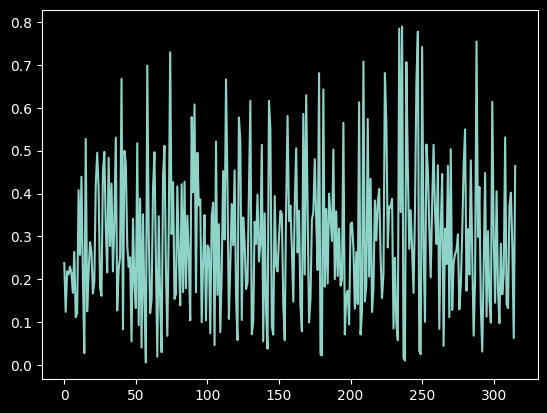

In [67]:
import matplotlib.pyplot as plt

plt.plot(distances)

음, 멋지네요! 거리가 짧은 구간과 거리가 먼 구간을 구분하는 게 흥미롭네요. 가장 눈에 띄는 건 outlier들이 넓게 퍼져 있는 모습입니다.

이러한 거리를 기준으로 에세이를 나누는 방법은 여러 가지가 있지만, 저는 거리의 95번째 백분위수를 넘는 모든 거리를 기준점으로 삼겠습니다. 설정해야 할 매개변수는 이것뿐입니다.

최종 시각화에서 빌드할 예정입니다. 반복적인 빌드와 개요는 영상을 참조하세요.

나온 청크들을 살펴봅시다.

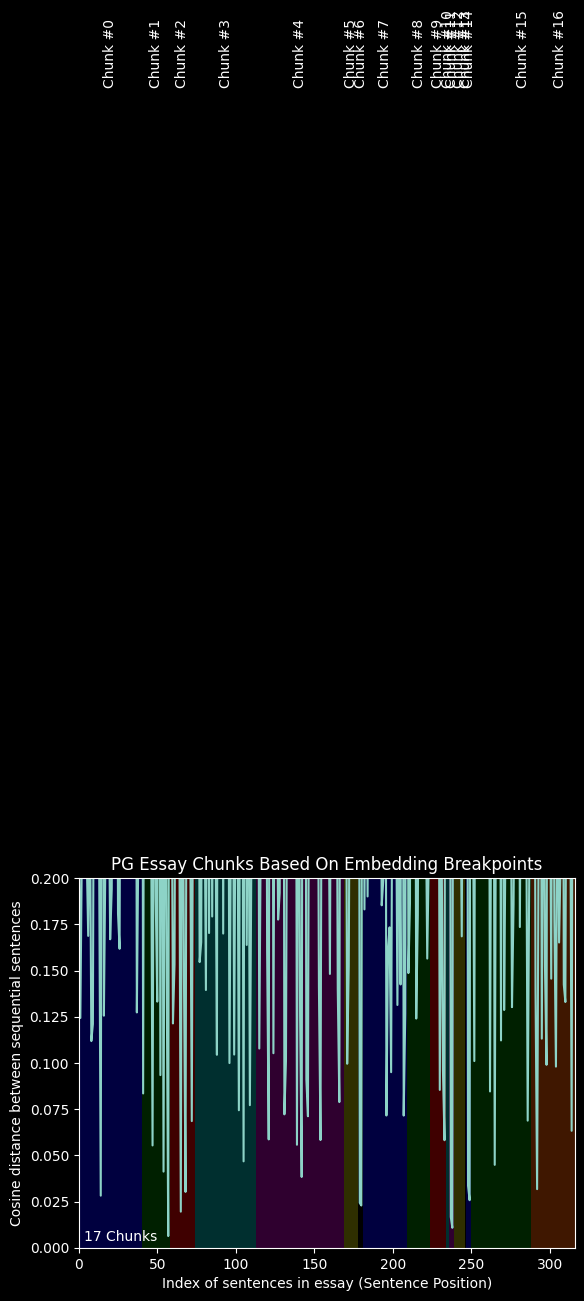

In [69]:
import numpy as np

plt.plot(distances)

y_upper_bound = 0.2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(
    distances, breakpoint_percentile_threshold
)  # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color="r", linestyle="-")

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len(
    [x for x in distances if x > breakpoint_distance_threshold]
)  # The amount of distances above your threshold
plt.text(
    x=(len(distances) * 0.01),
    y=y_upper_bound / 50,
    s=f"{num_distances_above_theshold + 1} Chunks",
)

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [
    i for i, x in enumerate(distances) if x > breakpoint_distance_threshold
]  # The indices of those breakpoints on your list

# Start of the shading and text
colors = ["b", "g", "r", "c", "m", "y", "k"]
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = (
        breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)
    )

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(
        x=np.average([start_index, end_index]),
        y=breakpoint_distance_threshold + (y_upper_bound) / 20,
        s=f"Chunk #{i}",
        horizontalalignment="center",
        rotation="vertical",
    )

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(
            last_breakpoint,
            len(distances),
            facecolor=colors[len(indices_above_thresh) % len(colors)],
            alpha=0.25,
        )
        plt.text(
            x=np.average([last_breakpoint, len(distances)]),
            y=breakpoint_distance_threshold + (y_upper_bound) / 20,
            s=f"Chunk #{i+1}",
            rotation="vertical",
        )

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

이제 시각화를 통해 주의를 돌리는 데 성공했으니, 문장들을 덩어리로 결합해야 합니다.

[23, 40, 51...]이라는 중단점이 있으므로, 문장 23에서 거리가 증가했으므로 첫 번째 청크를 0~22로 만들고 싶습니다.

In [70]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index : end_index + 1]
    combined_text = " ".join([d["sentence"] for d in group])
    chunks.append(combined_text)

    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = " ".join([d["sentence"] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

좋습니다. 이제 몇 가지를 직접 검사하여 제대로 보이는지 확인해 보겠습니다.

In [71]:
for i, chunk in enumerate(chunks[:2]):
    buffer = 200

    print(f"Chunk #{i}")
    print(chunk[:buffer].strip())
    print("...")
    print(chunk[-buffer:].strip())
    print("\n")

Chunk #0
Want to start a startup? Get funded by
Y Combinator. October 2006(This essay is derived from a talk at MIT.)
Till recently graduating seniors had two choices: get a job or go
to grad school. I think
...
e tell people not to? For the same reason that the probably
apocryphal violinist, whenever he was asked to judge someone's
playing, would always say they didn't have enough talent to make
it as a pro.


Chunk #1
Succeeding as a musician takes determination as well
as talent, so this answer works out to be the right advice for
everyone. The ones who are uncertain believe it and give up, and
the ones who are su
...
hs are: stamina, poverty, rootlessness,
colleagues, and ignorance.The importance of stamina shouldn't be surprising. If you've heard
anything about startups you've probably heard about the long hours.




이 방법은 아직 사용하기 어려운 방법이라는 점을 다시 한번 강조하고 싶습니다. 이 방법은 RAG eval을 통해 테스트하여 사용 사례에 적합한지 확인해야 합니다.

이 방법에서 청크 크기나 중첩은 고려하지 않았지만, 필요한 경우 큰 청크를 재귀적으로 분할할 수 있습니다.

How should it be improved? Let me [know](https://twitter.com/GregKamradt)! See me tease this [here](https://twitter.com/GregKamradt/status/1737921395974430953).

## Level 5: Agentic Chunking <a id="AgenticChunking"></a>
Taking level 4 even further - can we instruct an LLM to do this task like a human would?

How does a human even go about chunking in the first place?

Well...let me think, how would I go about chunking a document into its discrete parts such that the results were semantically similar?

1. I would get myself a scratch piece of paper or notepad
2. I'd start at the top of the essay and assume the first part will be a chunk (since we don't have any yet)
3. Then I would keep going down the essay and evaluate if a new sentence or piece of the essay should be a part of the first chunk, if not, then create a new one
4. Then keep doing that all the way down the essay until we got to the end.

Woah! Wait a minute - this is pseudo code for something we can try out. See me tease this [here](https://twitter.com/GregKamradt/status/1738276097471754735).

I debated whether or not to hold myself to the strict standard of using the *raw text* from a document, or use a derived form. The former felt like I was being too harsh, so I decided to explore using [propositions](https://twitter.com/LangChainAI/status/1735708004618764470). This is a cool concept ([research paper](https://arxiv.org/pdf/2312.06648.pdf)) that extracts stand alone statements from a raw piece of text.

Example: `Greg went to the park. He likes walking` > `['Greg went to the park.', 'Greg likes walking']`

Let's do it:

In [63]:
from langchain.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_community.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain.chains import create_extraction_chain
from typing import Optional, List
from langchain.chains import create_extraction_chain_pydantic
from langchain_core.pydantic_v1 import BaseModel
from langchain import hub

Pulling out propositions is done via a well-crafted prompt. I'm going to pull it from [LangHub](https://smith.langchain.com/hub?organizationId=50995362-9ea0-4378-ad97-b4edae2f9f22), LangChain's home for prompts.

You can view the proposition prompt [here](https://smith.langchain.com/hub/wfh/proposal-indexing?organizationId=50995362-9ea0-4378-ad97-b4edae2f9f22).

I'll use gpt-4 as the LLM because we aren't messing around. I care more about performance than I do speed or cost.

In [ ]:
obj = hub.pull("wfh/proposal-indexing")
llm = ChatOpenAI(
    model="gpt-4-1106-preview", openai_api_key=os.getenv("OPENAI_API_KEY", "YouKey")
)

Then I'll make a runnable w/ langchain, this'll be a short way to combine the prompt and llm

In [65]:
# use it in a runnable
runnable = obj | llm

The output from a runnable is a json-esque structure in a string. We need to pull the sentences out. I found that LangChain's example extraction was giving me a hard time so I'm doing it manually with a pydantic data class. There is definitely room to improve this.

Create your class then put it in an extraction chain.

In [ ]:
# Pydantic data class
class Sentences(BaseModel):
    sentences: List[str]


# Extraction
extraction_chain = create_extraction_chain_pydantic(pydantic_schema=Sentences, llm=llm)

Then wrap it together in a function that'll return a list of propositions to us

In [ ]:
def get_propositions(text):
    runnable_output = runnable.invoke({"input": text}).content

    propositions = extraction_chain.run(runnable_output)[0].sentences
    return propositions

Go get your text of choice.

In [ ]:
with open("../../data/PGEssays/superlinear.txt") as file:
    essay = file.read()

Then you need to decide what you send to your proposal maker. The prompt has an example that is about 1K characters long. So I would experiment with what works for you. This isn't another chunking decision, just pick something reasonable and try it out.

I'm using paragraphs

In [69]:
paragraphs = essay.split("\n\n")

Let's see how many we have

In [70]:
len(paragraphs)

53

That's too many for a demo, I'll do just the first couple to show it off.

In [ ]:
essay_propositions = []

for i, para in enumerate(paragraphs[:5]):
    propositions = get_propositions(para)

    essay_propositions.extend(propositions)
    print(f"Done with {i}")

Done with 0
Done with 1
Done with 2
Done with 3
Done with 4


Let's take a look at what the propositions look like

In [ ]:
print(f"You have {len(essay_propositions)} propositions")
essay_propositions[:10]

You have 26 propositions


['The month is October.',
 'The year is 2023.',
 'I did not understand the degree to which the returns for performance are superlinear when I was a child.',
 'The returns for performance are superlinear.',
 'Understanding the degree to which the returns for performance are superlinear is one of the most important things.',
 'Teachers and coaches implicitly told us the returns were linear.',
 'Teachers and coaches meant well.',
 "The phrase 'You get out what you put in' was heard a thousand times.",
 "The statement that 'You get out what you put in' is rarely true.",
 "If your product is only half as good as your competitor's product, you don't get half as many customers."]

So you'll see that they look like regular sentences, but they are actually statements that are able to stand on their own. For example, one of the sentences in the raw text is "They meant well, but this is rarely true." if you were to chunk that on it's own, the LLM would have no idea who you're talking about. Who meant well? What is rarely true? But those have been covered by the propositions.

Now onto the cool part, we need a system that can reason about each proposition and determine whether or not it should be a part of an existing chunk or if a new chunk should be made.

The pseudo code for how this works is above - I also review this code in the video so make sure to go watch that if you want to see me chat about it live.

The script is also in this repo if you've cloned it.

In [73]:
# mini script I made
from agentic_chunker import AgenticChunker

In [74]:
ac = AgenticChunker()

Then let's pass in our propositions to it. There are a lot in the full list so I'm only going to do a subset.

This method is slow and expensive, but let's see how the results are.

You can turn off the print statements via setting `ac = AgenticChunker(print_logging=False)` when you create your chunker.

In [75]:
ac.add_propositions(essay_propositions)


Adding: 'The month is October.'
No chunks, creating a new one


Created new chunk (fc52f): Date & Times

Adding: 'The year is 2023.'
Chunk Found (fc52f), adding to: Date & Times

Adding: 'I did not understand the degree to which the returns for performance are superlinear when I was a child.'
No chunks found
Created new chunk (a4a7e): Effort-Reward Relationship

Adding: 'The returns for performance are superlinear.'
Chunk Found (a4a7e), adding to: Effort-Reward Relationship

Adding: 'Understanding the degree to which the returns for performance are superlinear is one of the most important things.'
Chunk Found (a4a7e), adding to: Superlinear Returns in Performance

Adding: 'Teachers and coaches implicitly told us the returns were linear.'
No chunks found
Created new chunk (38e4a): Education & Coaching Returns

Adding: 'Teachers and coaches meant well.'
No chunks found
Created new chunk (0402d): Educational Approaches

Adding: 'The phrase 'You get out what you put in' was heard a thousand times.'
Chunk Found (38e4a), adding to: Education & Coaching R

Cool, looks like a few chunks were made. Let's check them out

In [76]:
ac.pretty_print_chunks()


You have 5 chunks

Chunk #0
Chunk ID: fc52f
Summary: This chunk contains information about specific dates and times related to the current month and year.
Propositions:
    -The month is October.
    -The year is 2023.



Chunk #1
Chunk ID: a4a7e
Summary: This chunk discusses the concept of superlinear returns across different sectors and its implications for understanding economic, social, and personal growth dynamics.
Propositions:
    -I did not understand the degree to which the returns for performance are superlinear when I was a child.
    -The returns for performance are superlinear.
    -Understanding the degree to which the returns for performance are superlinear is one of the most important things.
    -The returns for performance are superlinear in business.
    -Some people think the superlinear returns in business are a flaw of capitalism.
    -Some people think that changing the rules would stop the superlinear returns in business from being true.
    -Superlinear return

Awesome, then if we wanted to get the chunks properly, then we get extract a list of strings with them. The chunks propositions will be joined in the same string

In [ ]:
chunks = ac.get_chunks(get_type="list_of_strings")

In [78]:
chunks

['The month is October. The year is 2023.',
 'I did not understand the degree to which the returns for performance are superlinear when I was a child. The returns for performance are superlinear. Understanding the degree to which the returns for performance are superlinear is one of the most important things. The returns for performance are superlinear in business. Some people think the superlinear returns in business are a flaw of capitalism. Some people think that changing the rules would stop the superlinear returns in business from being true. Superlinear returns for performance are a feature of the world. Superlinear returns for performance are not an artifact of rules that humans have invented. The same pattern of superlinear returns is seen in fame. The same pattern of superlinear returns is seen in power. The same pattern of superlinear returns is seen in military victories. The same pattern of superlinear returns is seen in knowledge. The same pattern of superlinear returns is

Great, now we can go use that in our evaluations for your retrieval.

## Bonus Level: Alternative Representation <a id="BonusLevel"></a>
So far I've shown how to chunk up your raw text (okay, I was a bit liberal with level 5).

But what if your raw text isn't the best way to represent your data for your task?

For example, if you're doing semantic search on chat messages, raw chat messages may lack the context to make a successful embedding. Maybe actually trying to semantic search of a summary of a conversation would do better. Or maybe hypothetical questions that the chat would answer?

This is where the world of chunking/splitting starts to dive into the world of [indexing](https://docs.llamaindex.ai/en/stable/understanding/indexing/indexing.html#what-is-an-index). When you index, you're making a choice about how you want to represent your data in your data base or knowledge base.

This is more of a retrieval topic, but it's worth talking about with chunking.

Let's quickly go through a few popular alternative ways developers like to represent their data. There are unlimited methods to try. We'll review 4 of them

* **[Multi-Vector Indexing](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector)** - This is when you do semantic search for a vector that is derived from something other than your raw text
    * **Summaries** - A summary of your chunk
    * **Hypothetical questions** - Good for chat messages used as knowledge base
    * **Child Documents** - Parent Document Retriever
* **Graph Based Chunking** - Transposing your raw text into a graph structure

### Summaries
Instead of embedding your raw text, embed a summary of your raw text which will have more dense information

In [79]:
import uuid

from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryByteStore
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma

Let's use our Super Linear essay again. I'll split it into large chunks

In [ ]:
with open("../../data/PGEssays/superlinear.txt") as file:
    essay = file.read()

splitter = RecursiveCharacterTextSplitter(chunk_size=4000, chunk_overlap=0)

docs = splitter.create_documents([essay])

print(f"You have {len(docs)} docs")

You have 6 docs


Spin up a chain that will quickly summarize for you

In [83]:
chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | ChatOpenAI(max_retries=0)
    | StrOutputParser()
)

Then let's get the summaries

In [84]:
summaries = chain.batch(docs, {"max_concurrency": 5})

Let's look at a sample

In [85]:
summaries[0]

"The document discusses the concept of superlinear returns for performance, where the rewards for performance are not proportional to the effort put in. It explains that this concept is present in various aspects of life, such as business, fame, power, military victories, and benefit to humanity. The document emphasizes the importance of understanding this concept, especially for ambitious individuals. It also discusses how exponential growth and thresholds are fundamental causes of superlinear returns, using examples such as bacterial cultures and startups. The document also mentions Y Combinator's focus on growth rate as a key factor in achieving exponential growth. Additionally, it explores how humans are not naturally accustomed to exponential growth and discusses historical examples of exponential growth, such as empires."

Then we are going to create a vectorstore (holds vectors + summaries) and a docstore (holds raw docs)

In [86]:
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryByteStore()

id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

Then you want to create documents out of your summary list, add the doc_id to it's metadata. This will tie it back to the original document so you know which summary goes with which original doc.

In [87]:
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

Then add them both to your vectorestore and docstore. When you add the docs to the vectorstore it will get the embeddings for them too.

In [88]:
# Adds the summaries
retriever.vectorstore.add_documents(summary_docs)

# Adds the raw documents
retriever.docstore.mset(list(zip(doc_ids, docs)))

Then if you want you can add the original docs to the vectorstore as well. Just make sure to add the doc id to it as well so you can tie it all together

In [89]:
# for i, doc in enumerate(docs):
#     doc.metadata[id_key] = doc_ids[i]
# retriever.vectorstore.add_documents(docs)

Great, now that we've done all that work, let's try a search. If you run the code below, you'll search on the summary embeddings, but you'll get the raw documents returned.

In [90]:
# retriever.get_relevant_documents(query="the concept of superlinear returns, which refers to the idea that the returns for performance are not linear")

### Hypothetical Questions
You can generate hypothetical questions about your raw documents. Check out [LangChain's](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#hypothetical-queries) implementation of it for more information.

This is espeically helpful when you have sparse unstructured data, like chat messages.

Say you were to build a bot that uses slack conversations as a knowledge base. Trying to do semantic search on raw chat messages might not have the greatest results. However, if you were to generate hypothetical questions that the slack messages would answer, then when you get a new question in, you'll likely have a better chance matching.

The code for this will be the same as the summary code, but instead of asking the LLM to make a summary, you'll ask it for hypothetical questions.

### Parent Document Retriever (PDR)
Much like the previous two, Parent Document Retriever builds on the concept of doing semantic search on a varied representation of your data.

The hypothesis with the PDR is that smaller chunks have a higher likely hood of being matched semantically with a potential query. However, those smaller chunks may not have all the context they need, so instead of passing the smaller chunks to your LLM, get the parent chunk of the smaller chunk. This means you get a larger chunk which the smaller chunk is placed in.

Check out LangChain's implementation's implementation of it [here](https://python.langchain.com/docs/modules/data_connection/retrievers/parent_document_retriever).

I have a full tutorial on it at [FullStackRetrieval.com](https://fullstackretrieval.com/) if you want to go deeper on that.

I want to quickly go over a similar method in [Llama Index](https://www.llamaindex.ai/) with their `HierarchicalNodeParser` which will split a document at various chunk sizes (there will be a bunch of overlaps but that is the purpose). When combined with their `AutoMergingRetriever` you can do complicated retrieval easily. Their walkthrough [here](https://docs.llamaindex.ai/en/stable/examples/retrievers/auto_merging_retriever.html).

In [ ]:
from llama_index.node_parser import HierarchicalNodeParser

node_parser = HierarchicalNodeParser.from_defaults(
    chunk_sizes=[2048, 512, 128], chunk_overlap=0
)

In [92]:
documents = SimpleDirectoryReader(
    input_files=["../../data/PGEssays/mit.txt"]
).load_data()

Then let's do our splitting. There will be a bunch of chunks since we included `128` as a chunk size above

In [93]:
nodes = node_parser.get_nodes_from_documents(documents)

In [ ]:
print(f"You have {len(nodes)} nodes")

You have 118 nodes


Then let's look at the relationships that are available to one of the small nodes at the end

In [95]:
nodes[-2].relationships

{<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e3cee07e-460b-4cc9-95ad-93fc4bba0f58', node_type=<ObjectType.TEXT: '1'>, metadata={'file_path': '../../data/PGEssays/mit.txt', 'file_name': 'mit.txt', 'file_type': 'text/plain', 'file_size': 36045, 'creation_date': '2024-01-22', 'last_modified_date': '2023-12-21', 'last_accessed_date': '2024-03-11'}, hash='6e91b93d9f1ccaca77ad93ca986701dcb3e0605f685a67338cf1cf7350fb9236'),
 <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='ffbeb21c-1920-404c-9ffa-2dfa453a4a8f', node_type=<ObjectType.TEXT: '1'>, metadata={'file_path': '../../data/PGEssays/mit.txt', 'file_name': 'mit.txt', 'file_type': 'text/plain', 'file_size': 36045, 'creation_date': '2024-01-22', 'last_modified_date': '2023-12-21', 'last_accessed_date': '2024-03-11'}, hash='4c3163fbaee0bc2de2bbcb5decca5cf81cc839d85f294039af0f9c848acf6c11'),
 <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='3462052a-d7d3-491a-9930-511bf6b6583b', node_type=<ObjectType.TEXT: '1'>, m

You can see there are source, previous, next, and parent. For [more information on these](https://docs.llamaindex.ai/en/stable/api/llama_index.schema.NodeRelationship.html).

### Graph Structure
If your data is rich with entities, relationships, and connections, then a graph structure may be best for you.

Few options:
* [Diffbot](https://www.diffbot.com/)
* [InstaGraph](https://github.com/yoheinakajima/instagraph) - By [Yohei](https://twitter.com/yoheinakajima)

I'll run through the LangChain supported version of Diffbot due to brevity. You'll need an API key from DB

In [ ]:
# !pip3 install langchain langchain-experimental openai neo4j wikipedia

from langchain_experimental.graph_transformers.diffbot import DiffbotGraphTransformer

diffbot_nlp = DiffbotGraphTransformer(
    diffbot_api_key=os.getenv("DIFFBOT_API_KEY", "YourKey")
)

In [97]:
text = """
Greg is friends with Bobby. San Francisco is a great city, but New York is amazing.
Greg lives in New York. 
"""
docs = [Document(page_content=text)]

In [98]:
graph_documents = diffbot_nlp.convert_to_graph_documents(docs)

In [99]:
graph_documents

[GraphDocument(nodes=[Node(id='Greg', type='Person', properties={'name': 'Greg'}), Node(id='http://www.wikidata.org/entity/Q60', type='Location', properties={'name': 'New York City'}), Node(id='Bobby', type='Person', properties={'name': 'Bobby'})], relationships=[Relationship(source=Node(id='Greg', type='Person'), target=Node(id='http://www.wikidata.org/entity/Q60', type='Location'), type='PERSON_LOCATION', properties={'evidence': 'Greg lives in New York.', 'isCurrent': 'true'}), Relationship(source=Node(id='Greg', type='Person'), target=Node(id='http://www.wikidata.org/entity/Q60', type='Location'), type='PERSON_LOCATION', properties={'evidence': 'Greg lives in New York.', 'isCurrent': 'true'}), Relationship(source=Node(id='Greg', type='Person'), target=Node(id='Bobby', type='Person'), type='SOCIAL_RELATIONSHIP', properties={'evidence': 'Greg is friends with Bobby.'})], source=Document(page_content='\nGreg is friends with Bobby. San Francisco is a great city, but New York is amazing.\

## Wrap up

Congratulations on making it to the end of this video. The aim was to educate you on the chunking theory, give a nod to retrieval, and encourage you to try out these methods on your data.

I always like hearing what you think about the code, video or how you use this in your role. Let me know on [twitter](https://twitter.com/GregKamradt) or email (contact@dataindependent.com)